In [2]:
# packages
import pandas as pd
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from osgeo import gdal
from rasterio.warp import calculate_default_transform, reproject
import geopandas as gpd
from rasterio.mask import mask

Predict the difference in Normalized Difference Vegetation Index for 2025 and 2028

Test Area: Csarf Smith River Complex (08/2023 - 11/2023)

Training Area: Ferguson Fire (07/2018 - 08/2018)

In [3]:
def resample_raster_1(src_raster, target_profile, out_path):
    with rio.open(src_raster) as src:
        out_shape = (
            src.count,
            target_profile['height'],
            target_profile['width']
        )
        
        src_data = src.read(
            out_shape=out_shape,
            resampling=Resampling.bilinear
        )
        
        transform = src.transform * src.transform.scale(
            (src.width / src_data.shape[-1]),
            (src.height / src_data.shape[-2])
        )
        
        profile = src.profile
        profile.update({
            'height': src_data.shape[1],
            'width': src_data.shape[2],
            'transform': transform
        })
        
        with rio.open(out_path, 'w', **profile) as dst:
            dst.write(src_data)

In [4]:
target_raster_path_1 = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIVclip.tif'
with rio.open(target_raster_path_1) as target_raster:
    target_profile_1 = target_raster.profile

target_raster_path_2 = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIVclip.tif'
with rio.open(target_raster_path_2) as target_raster:
    target_profile_2 = target_raster.profile

In [5]:
# path to areas for resizing training set 1
src_rasters_1 = [
    '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIVclip.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/[2]One_CaliforniaPostFireNDIVclip.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/[5]One_CaliforniaPostFireNDIVclip.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIV_SLOPE.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIV_ASPECT.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPRECIPITATION.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaSOILMOISTURE.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaEVAPOTRANSPIRATION.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireclip_DEM.tif'
]

# saving rasters 
resampled_rasters = []
for src_raster in src_rasters_1:
    resampled_path_1 = src_raster.replace('.tif', '_resampled.tif')
    resample_raster_1(src_raster, target_profile_1, resampled_path_1)
    resampled_rasters.append(resampled_path_1)

# path to areas for resizing training set 2
src_rasters_2 = [
    '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIVclip.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/[2]Two_CaliforniaPostFireNDIVclip.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/[5]Two_CaliforniaPostFireNDIVclip.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIV_SLOPE.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIV_ASPECT.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPRECIPITATION.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaSOILMOISTURE.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaEVAPOTRANSPIRATION.tif',
    '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireclip_DEM.tif'
]

# saving rasters 
resampled_rasters = []
for src_raster in src_rasters_2:
    resampled_path_2 = src_raster.replace('.tif', '_resampled.tif')
    resample_raster_1(src_raster, target_profile_2, resampled_path_2)
    resampled_rasters.append(resampled_path_2)

In [6]:
# reading geotiff data
def load_data(file_path):
    with rio.open(file_path) as src:
        return src.read(1), src.transform

In [7]:
# enable GDAL exceptions
gdal.UseExceptions()

# california training set 1
one_SRCCaliforniaTrainingPreFire = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIVclip_resampled.tif'
one_SRCcaliforniaTrainingNDIV2 = '/home/jovyan/NASACODE/NASAMLFiles/[2]One_CaliforniaPostFireNDIVclip_resampled.tif'
one_SRCcaliforniaTrainingNDIV5 = '/home/jovyan/NASACODE/NASAMLFiles/[5]One_CaliforniaPostFireNDIVclip_resampled.tif'
one_SRCcaliforniaTrainingSlope = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIV_SLOPE_resampled.tif'
one_SRCcaliforniaTrainingAspect = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIV_ASPECT_resampled.tif'
one_SRCcaliforniaPrecipitation = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPRECIPITATION_resampled.tif'
one_SRCcaliforniaSoilMoisture = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaSOILMOISTURE_resampled.tif'
one_SRCcaliforniaEvapotranspiration = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaEVAPOTRANSPIRATION_resampled.tif'
one_SRCcaliforniaTrainingDEM = '/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireclip_DEM_resampled.tif'

# loading data for training set 1
preFire1, transform1_preFire = load_data(one_SRCCaliforniaTrainingPreFire)
train1_NDIVdifferenceYear2, train1_transform2 = load_data(one_SRCcaliforniaTrainingNDIV2)
train1_NDIVdifferenceYear5, train1_transform5 = load_data(one_SRCcaliforniaTrainingNDIV5)
train1_slope, train1_transformSlope = load_data(one_SRCcaliforniaTrainingSlope)
train1_aspect, train1_transformAspect = load_data(one_SRCcaliforniaTrainingAspect)
train1_precipitation, train1_transformPT = load_data(one_SRCcaliforniaPrecipitation)
train1_soilMoisture, train1_transformSM = load_data(one_SRCcaliforniaSoilMoisture)
train1_evapotranspiration, train1_transformEVT = load_data(one_SRCcaliforniaEvapotranspiration)
dem1, transform1_dem= load_data(one_SRCcaliforniaTrainingDEM)

In [8]:
# enable GDAL exceptions
gdal.UseExceptions()

# california training set 1
two_SRCCaliforniaTrainingPreFire = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIVclip_resampled.tif'
two_SRCcaliforniaTrainingNDIV2 = '/home/jovyan/NASACODE/NASAMLFiles/[2]Two_CaliforniaPostFireNDIVclip_resampled.tif'
two_SRCcaliforniaTrainingNDIV5 = '/home/jovyan/NASACODE/NASAMLFiles/[5]Two_CaliforniaPostFireNDIVclip_resampled.tif'
two_SRCcaliforniaTrainingSlope = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIV_SLOPE_resampled.tif'
two_SRCcaliforniaTrainingAspect = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIV_ASPECT_resampled.tif'
two_SRCcaliforniaPrecipitation = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPRECIPITATION_resampled.tif'
two_SRCcaliforniaSoilMoisture = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaSOILMOISTURE_resampled.tif'
two_SRCcaliforniaEvapotranspiration = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaEVAPOTRANSPIRATION_resampled.tif'
two_SRCcaliforniaTrainingDEM = '/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireclip_DEM_resampled.tif'

# loading data for training set 1
preFire2, transform1_preFire = load_data(two_SRCCaliforniaTrainingPreFire)
train2_NDIVdifferenceYear2, train2_transform2 = load_data(two_SRCcaliforniaTrainingNDIV2)
train2_NDIVdifferenceYear5, train2_transform5 = load_data(two_SRCcaliforniaTrainingNDIV5)
train2_slope, train2_transformSlope = load_data(two_SRCcaliforniaTrainingSlope)
train2_aspect, train2_transformAspect = load_data(two_SRCcaliforniaTrainingAspect)
train2_precipitation, train2_transformPT = load_data(two_SRCcaliforniaPrecipitation)
train2_soilMoisture, train2_transformSM = load_data(two_SRCcaliforniaSoilMoisture)
train2_evapotranspiration, train2_transformEVT = load_data(two_SRCcaliforniaEvapotranspiration)
dem2, transform2_dem= load_data(two_SRCcaliforniaTrainingDEM)

In [9]:
# ensuring equivalent dimensions
assert preFire1.shape == train1_NDIVdifferenceYear2.shape  == train1_NDIVdifferenceYear5.shape == train1_slope.shape == train1_aspect.shape == train1_precipitation.shape == train1_soilMoisture.shape == train1_evapotranspiration.shape == dem1.shape
assert preFire2.shape == train2_NDIVdifferenceYear2.shape  == train2_NDIVdifferenceYear5.shape == train2_slope.shape == train2_aspect.shape == train2_precipitation.shape == train2_soilMoisture.shape == train2_evapotranspiration.shape == dem2.shape

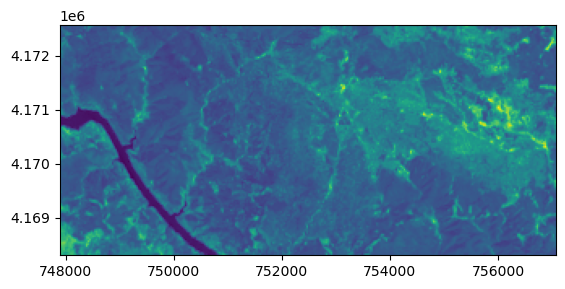

<Axes: >

In [10]:
one_SRCCaliforniaTrainingPreFirePLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIVclip_resampled.tif")
show(one_SRCCaliforniaTrainingPreFirePLOT)

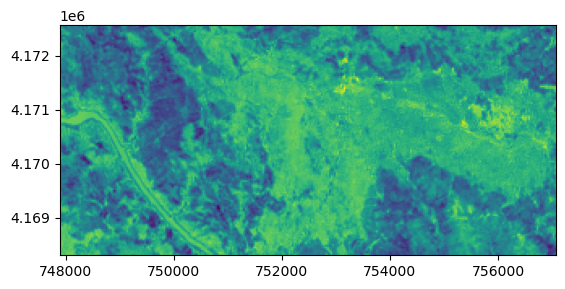

<Axes: >

In [11]:
one_SRCCaliforniaTrainingNDIV2PLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/[2]One_CaliforniaPostFireNDIVclip_resampled.tif")
show(one_SRCCaliforniaTrainingNDIV2PLOT)

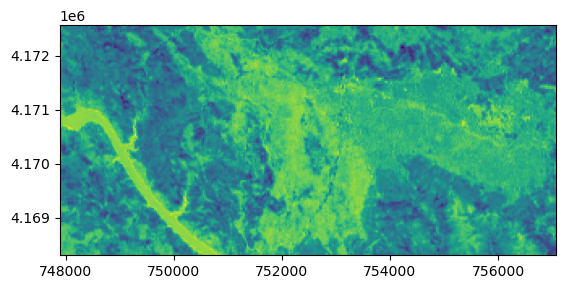

<Axes: >

In [12]:
one_SRCCaliforniaTrainingNDIV5PLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/[5]One_CaliforniaPostFireNDIVclip_resampled.tif")
show(one_SRCCaliforniaTrainingNDIV5PLOT)

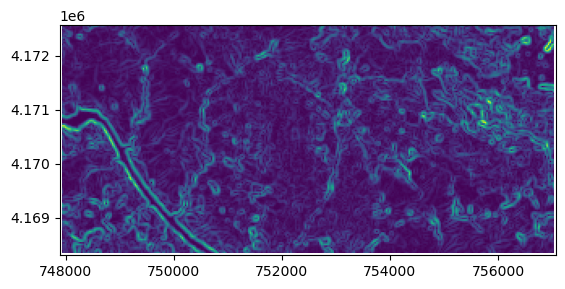

<Axes: >

In [13]:
one_SRCcaliforniaTrainingSlopePLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIV_SLOPE_resampled.tif")
show(one_SRCcaliforniaTrainingSlopePLOT)

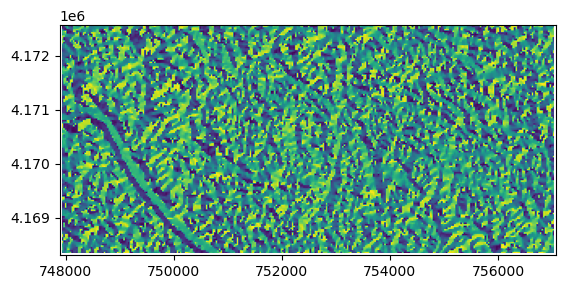

<Axes: >

In [14]:
one_SRCcaliforniaTrainingAspectPLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireNDIV_ASPECT_resampled.tif")
show(one_SRCcaliforniaTrainingAspectPLOT)

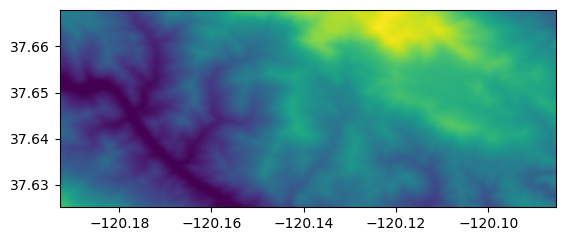

<Axes: >

In [15]:
one_SRCcaliforniaTrainingDEMPLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPreFireclip_DEM_resampled.tif")
show(one_SRCcaliforniaTrainingDEMPLOT)

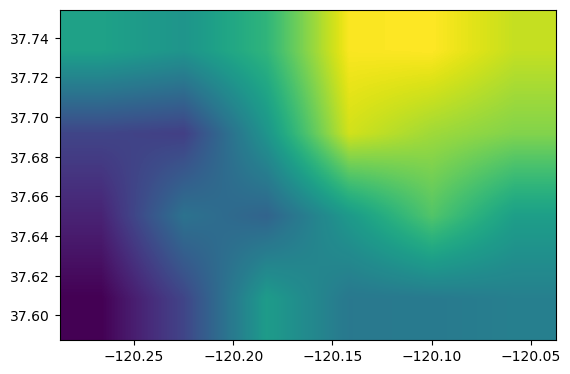

<Axes: >

In [16]:
one_SRCcaliforniaPrecipitation = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaPRECIPITATION_resampled.tif")
show(one_SRCcaliforniaPrecipitation)

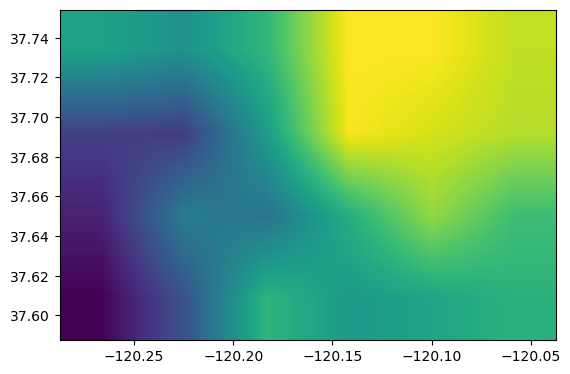

<Axes: >

In [17]:
one_SRCcaliforniaSoilMoisture = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaSOILMOISTURE_resampled.tif")
show(one_SRCcaliforniaSoilMoisture)

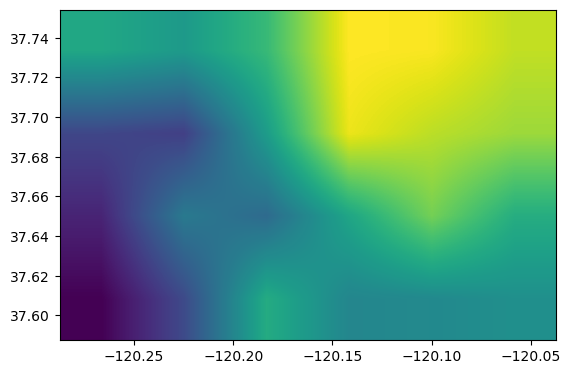

<Axes: >

In [18]:
one_SRCcaliforniaEvapotranspiration = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/One_CaliforniaEVAPOTRANSPIRATION_resampled.tif")
show(one_SRCcaliforniaEvapotranspiration)

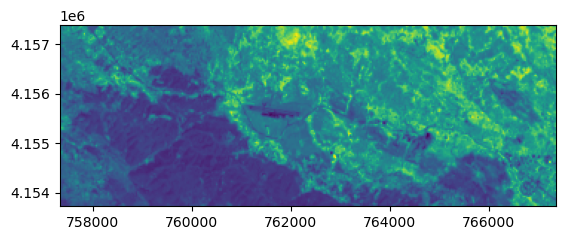

<Axes: >

In [19]:
two_SRCCaliforniaTrainingPreFirePLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIVclip_resampled.tif")
show(two_SRCCaliforniaTrainingPreFirePLOT)

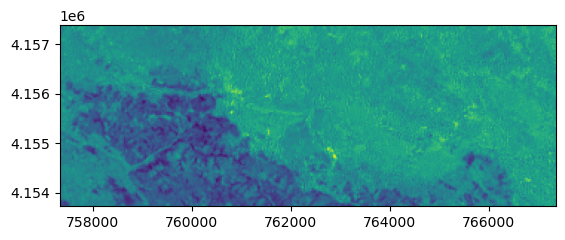

<Axes: >

In [20]:
two_SRCCaliforniaTrainingNDIV2PLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/[2]Two_CaliforniaPostFireNDIVclip_resampled.tif")
show(two_SRCCaliforniaTrainingNDIV2PLOT)

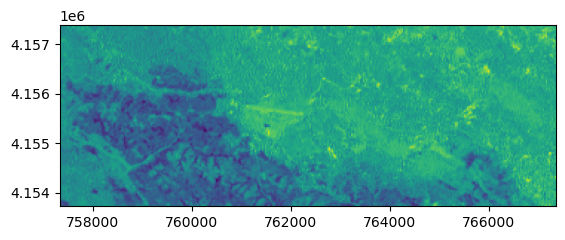

<Axes: >

In [21]:
two_SRCCaliforniaTrainingNDIV5PLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/[5]Two_CaliforniaPostFireNDIVclip_resampled.tif")
show(two_SRCCaliforniaTrainingNDIV5PLOT)

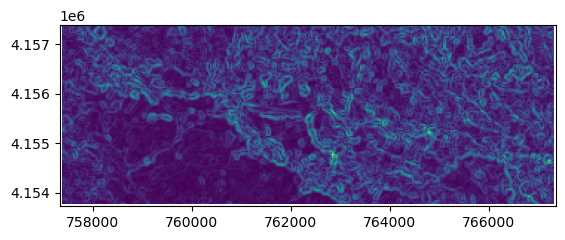

<Axes: >

In [22]:
two_SRCcaliforniaTrainingSlopePLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIV_SLOPE_resampled.tif")
show(two_SRCcaliforniaTrainingSlopePLOT)

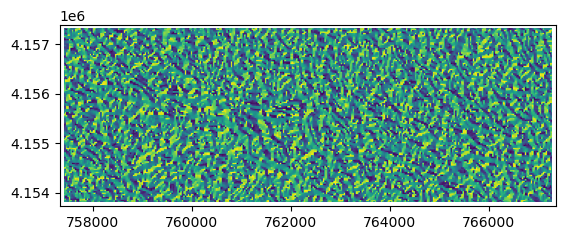

<Axes: >

In [23]:
two_SRCcaliforniaTrainingAspectPLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireNDIV_ASPECT_resampled.tif")
show(two_SRCcaliforniaTrainingAspectPLOT)

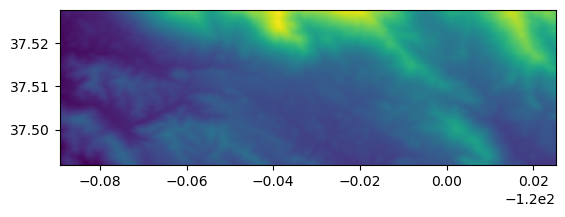

<Axes: >

In [24]:
two_SRCcaliforniaTrainingDEMPLOT = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPreFireclip_DEM_resampled.tif")
show(two_SRCcaliforniaTrainingDEMPLOT)

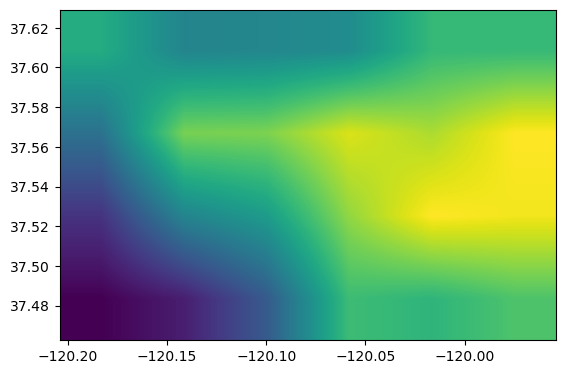

<Axes: >

In [25]:
two_SRCcaliforniaTrainingPrecipitation = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaPRECIPITATION_resampled.tif")
show(two_SRCcaliforniaTrainingPrecipitation)

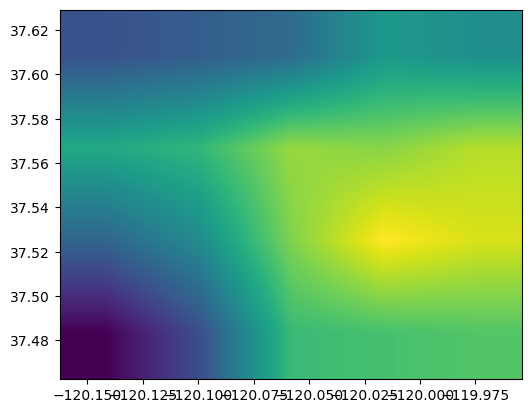

<Axes: >

In [26]:
two_SRCcaliforniaSoilMoisture = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaSOILMOISTURE_resampled.tif")
show(two_SRCcaliforniaSoilMoisture)

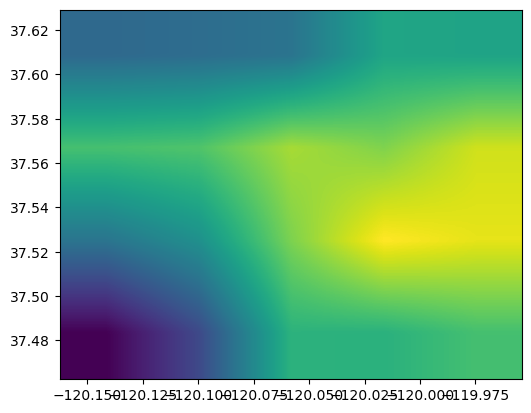

<Axes: >

In [27]:
two_SRCcaliforniaEvapotranspiration = rio.open(r"/home/jovyan/NASACODE/NASAMLFiles/Two_CaliforniaEVAPOTRANSPIRATION_resampled.tif")
show(two_SRCcaliforniaEvapotranspiration)

In [28]:
# flatten the arrays and remove NaN values for both sets
pre_fire_flat_1 = preFire1.flatten()
ndiv_diff_year2_1_flat = train1_NDIVdifferenceYear2.flatten()
ndiv_diff_year5_1_flat = train1_NDIVdifferenceYear5.flatten()
slope_flat_1 = train1_slope.flatten()
aspect_flat_1 = train1_aspect.flatten()
PT_flat_1 = train1_precipitation.flatten()
SM_flat_1 = train1_soilMoisture.flatten()
EVT_flat_1 = train1_evapotranspiration.flatten()
dem1_flat = dem1.flatten()

pre_fire_flat_2 = preFire2.flatten()
ndiv_diff_year2_2_flat = train2_NDIVdifferenceYear2.flatten()
ndiv_diff_year5_2_flat = train2_NDIVdifferenceYear5.flatten()
slope_flat_2 = train2_slope.flatten()
aspect_flat_2 = train2_aspect.flatten()
PT_flat_2 = train2_precipitation.flatten()
SM_flat_2 = train2_soilMoisture.flatten()
EVT_flat_2 = train2_evapotranspiration.flatten()
dem2_flat = dem2.flatten()

In [29]:
# combine the data from both sets
X_pre_fire = np.concatenate((pre_fire_flat_1, pre_fire_flat_2))
X_post_fire_2yr = np.concatenate((ndiv_diff_year2_1_flat, ndiv_diff_year2_2_flat))
X_post_fire_5yr = np.concatenate((ndiv_diff_year5_1_flat, ndiv_diff_year5_2_flat))
X_dem = np.concatenate((dem1_flat, dem2_flat))
X_slope = np.concatenate((slope_flat_1, slope_flat_2))
X_aspect = np.concatenate((aspect_flat_1, aspect_flat_2))
X_PT = np.concatenate((PT_flat_1, PT_flat_2))
X_SM = np.concatenate((SM_flat_1, SM_flat_2))
X_EVT = np.concatenate((EVT_flat_1, EVT_flat_2))
y_year2 = np.concatenate((ndiv_diff_year2_1_flat, ndiv_diff_year2_2_flat))
y_year5 = np.concatenate((ndiv_diff_year5_1_flat, ndiv_diff_year5_2_flat))

In [30]:
# remove NaN values
valid_mask = ~np.isnan(X_pre_fire) & ~np.isnan(X_post_fire_2yr) & ~np.isnan(X_post_fire_5yr) & ~np.isnan(X_dem) & ~np.isnan(X_slope) & ~np.isnan(X_aspect) & ~np.isnan(X_PT) & ~np.isnan(X_SM) & ~np.isnan(X_EVT) & ~np.isnan(y_year2) & ~np.isnan(y_year5)
X_pre_fire_valid = X_pre_fire[valid_mask].reshape(-1, 1)
X_post_fire_2yr_valid = X_post_fire_2yr[valid_mask].reshape(-1, 1)
X_post_fire_5yr_valid = X_post_fire_5yr[valid_mask].reshape(-1, 1)
X_dem_valid = X_dem[valid_mask].reshape(-1, 1)
X_slope_valid = X_slope[valid_mask].reshape(-1, 1)
X_aspect_valid = X_aspect[valid_mask].reshape(-1, 1)
X_PT_valid = X_PT[valid_mask].reshape(-1, 1)
X_SM_valid = X_SM[valid_mask].reshape(-1, 1)
X_EVT_valid = X_EVT[valid_mask].reshape(-1, 1)


# adding weight factor to independent variables (MAY ADDRESS LATER...)
# factor = 5
# X_pre_fire_valid *= factor
# X_post_fire_2yr_valid *= factor
# X_post_fire_5yr_valid *= factor


X_valid = np.hstack((X_pre_fire_valid, X_dem_valid, X_slope_valid, X_aspect_valid, X_PT_valid, X_SM_valid, X_EVT_valid))
y_year2_valid = y_year2[valid_mask]
y_year5_valid = y_year5[valid_mask]

In [31]:
# training the data
X_train, X_test, y_year2_train, y_year2_test, y_year5_train, y_year5_test = train_test_split(X_valid, y_year2_valid, y_year5_valid, test_size=0.3, random_state=42)

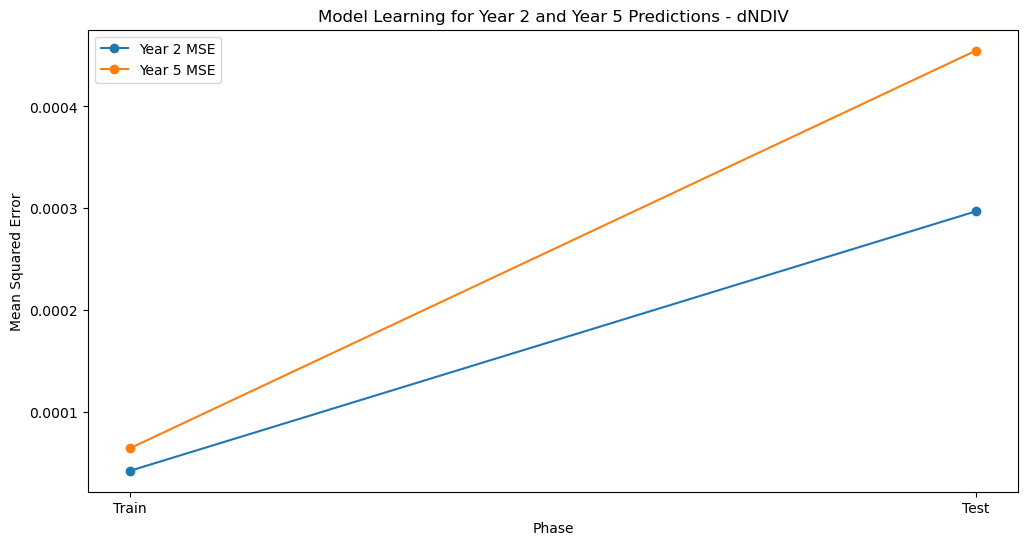

<Figure size 640x480 with 0 Axes>

In [50]:
# initialize the Random Forest regressors
model_year2 = RandomForestRegressor(max_depth=1)
model_year2.fit(X_train, y_year2_train)
mse2_train = model_year2.predict(X_train)
mse_year2_train = mean_squared_error(mse2_train, y_year2_train)

model_year2 = RandomForestRegressor(max_depth=None)
model_year2.fit(X_train, y_year2_train)
mse2_train = model_year2.predict(X_train)
mse_year2_train = mean_squared_error(mse2_train, y_year2_train)
y_year2_pred = model_year2.predict(X_test)
mse_year2_test = mean_squared_error(y_year2_test, y_year2_pred)

# train the Random Forest model for Year 5 prediction
model_year5 = RandomForestRegressor(max_depth=1)
model_year5.fit(X_train, y_year5_train)
mse5_train = model_year5.predict(X_train)
mse_year5_train = mean_squared_error(mse5_train, y_year5_train)

model_year5 = RandomForestRegressor(max_depth=None)
model_year5.fit(X_train, y_year5_train)
mse5_train = model_year5.predict(X_train)
mse_year5_train = mean_squared_error(mse5_train, y_year5_train)
y_year5_pred = model_year5.predict(X_test)
mse_year5_test = mean_squared_error(y_year5_test, y_year5_pred)

# get feature importances for both models
importances_year2 = model_year2.feature_importances_
importances_year5 = model_year5.feature_importances_

# plot MSE for Year 2 and Year 5
plt.figure(figsize=(12, 6))
plt.plot([1, 2], [mse_year2_train, mse_year2_test], marker='o', label='Year 2 MSE')
plt.plot([1, 2], [mse_year5_train, mse_year5_test], marker='o', label='Year 5 MSE')
plt.xticks([1, 2], ['Train', 'Test'])
plt.xlabel('Phase')
plt.ylabel('Mean Squared Error')
plt.title('Model Learning for Year 2 and Year 5 Predictions - dNDIV')
plt.legend()
plt.show()
plt.savefig('ModelLearningforYear2andYear5PredictionsNDIV.png')

In [37]:
def resample_raster_2(src_raster, match_raster_path, out_path):
    with rio.open(match_raster_path) as match_raster:
        match_transform = match_raster.transform
        match_crs = match_raster.crs
        match_width = match_raster.width
        match_height = match_raster.height

    with rio.open(src_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, match_crs, match_width, match_height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': match_crs,
            'transform': match_transform,
            'width': match_width,
            'height': match_height
        })

        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=match_transform,
                    dst_crs=match_crs,
                    resampling=Resampling.bilinear
                )

In [38]:
dem_file_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestNDIV_DEM.tif'
pre_fire_file_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaPreFireNDIVclip.tif'
post_fire_2month_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaPreFireNDIVclip.tif'
slope_file_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaPreFireNDIV_SLOPE.tif'
aspect_file_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaPreFireNDIV_ASPECT.tif'
PT_file_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestPrecipitation.tif'
SM_file_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestSoilMoisture.tif'
EVT_file_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestEvapotranspiration.tif'
resampled_dem_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestNDIVclip.tif'
resampled_slope_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaPreFireNDIVclip_SLOPE.tif'
resampled_aspect_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaPreFireNDIVclip_ASPECT.tif'
resampled_PT_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestPrecipitation.tif'
resampled_SM_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestSoilMoisture.tif'
resampled_EVT_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestEvapotranspiration.tif'
resampled_2month_path = '/home/jovyan/NASACODE/NASAMLFiles/CaliforniaTestFireNDIVclip.tif'

# resample the DEM data to match the pre-fire GeoTIFF dimensions
resample_raster_2(dem_file_path, pre_fire_file_path, resampled_dem_path)
resample_raster_2(slope_file_path, pre_fire_file_path, resampled_slope_path)
resample_raster_2(aspect_file_path, pre_fire_file_path, resampled_aspect_path)
resample_raster_2(PT_file_path, pre_fire_file_path, resampled_PT_path)
resample_raster_2(SM_file_path, pre_fire_file_path, resampled_SM_path)
resample_raster_2(EVT_file_path, pre_fire_file_path, resampled_EVT_path)
resample_raster_2(post_fire_2month_path, pre_fire_file_path, resampled_2month_path)

In [39]:
# load the test NBR data
test_pre_fire, test_transform_pre_fire = load_data(pre_fire_file_path)
test_post_fire_2months, test_transform_post_fire = load_data(resampled_2month_path)
test_dem, test_transform_dem = load_data(resampled_dem_path)
test_slope, test_transform_slope = load_data(resampled_slope_path)
test_aspect, test_transform_aspect = load_data(resampled_aspect_path)
test_PT, test_transform_PT = load_data(resampled_PT_path)
test_SM, test_transform_SM = load_data(resampled_SM_path)
test_EVT, test_transform_EVT = load_data(resampled_EVT_path)

print(f"Shape of test_pre_fire: {test_pre_fire.shape}")
print(f"Shape of test_post_fire_2months: {test_post_fire_2months.shape}")
print(f"Shape of test_dem: {test_dem.shape}")
print(f"Shape of test_slope: {test_slope.shape}")
print(f"Shape of test_aspect: {test_aspect.shape}")
print(f"Shape of test_PT: {test_PT.shape}")
print(f"Shape of test_SM: {test_SM.shape}")
print(f"Shape of test_EVT: {test_EVT.shape}")


assert test_pre_fire.shape == test_post_fire_2months.shape == test_dem.shape == test_slope.shape == test_aspect.shape == test_PT.shape == test_SM.shape == test_EVT.shape

# flatten the test arrays and remove NaN values
test_pre_fire_flat = test_pre_fire.flatten()
test_post_fire_2months_flat = test_post_fire_2months.flatten()
test_dem_flat = test_dem.flatten()
test_slope_flat = test_slope.flatten()
test_aspect_flat = test_aspect.flatten()
test_PT_flat = test_PT.flatten()
test_SM_flat = test_SM.flatten()
test_EVT_flat = test_EVT.flatten()
valid_mask_test = ~np.isnan(test_pre_fire_flat) & ~np.isnan(test_post_fire_2months_flat) & ~np.isnan(test_dem_flat) & ~np.isnan(test_slope_flat) & ~np.isnan(test_aspect_flat) & ~np.isnan(test_PT_flat) & ~np.isnan(test_SM_flat) & ~np.isnan(test_EVT_flat)

print(f"Shape of test_pre_fire_flat: {test_pre_fire_flat.shape}")
print(f"Shape of test_post_fire_2months_flat: {test_post_fire_2months_flat.shape}")
print(f"Shape of test_dem_flat: {test_dem_flat.shape}")
print(f"Shape of test_slope_flat: {test_slope_flat.shape}")
print(f"Shape of test_aspect_flat: {test_aspect_flat.shape}")
print(f"Shape of test_PT_flat: {test_PT_flat.shape}")
print(f"Shape of test_SM_flat: {test_SM_flat.shape}")
print(f"Shape of test_EVT_flat: {test_EVT_flat.shape}")
print(f"Shape of valid_mask_test: {valid_mask_test.shape}")
print(f"Number of True in valid_mask_test: {np.sum(valid_mask_test)}")

assert valid_mask_test.shape[0] == test_pre_fire_flat.shape[0], "AssertionError: Mask and data shape mismatch"

# stack pre-fire and 2-month NBR differences as features
test_X_pre_fire_valid = test_pre_fire_flat[valid_mask_test].reshape(-1, 1)
test_X_dem_valid = test_dem_flat[valid_mask_test].reshape(-1, 1)
test_X_slope_valid = test_slope_flat[valid_mask_test].reshape(-1, 1)
test_X_aspect_valid = test_aspect_flat[valid_mask_test].reshape(-1, 1)
test_X_PT_valid = test_PT_flat[valid_mask_test].reshape(-1, 1)
test_X_SM_valid = test_SM_flat[valid_mask_test].reshape(-1, 1)
test_X_EVT_valid = test_EVT_flat[valid_mask_test].reshape(-1, 1)
test_X_valid = np.hstack((test_X_pre_fire_valid, test_X_dem_valid, test_X_slope_valid, test_X_aspect_valid, test_X_PT_valid, test_X_SM_valid, test_X_EVT_valid))


# predict year 2 and year 5 NBR differences for the test data
test_y_year2_pred = model_year2.predict(test_X_valid)
test_y_year5_pred = model_year5.predict(test_X_valid)

# reshape the predictions back to the original GeoTIFF shape
test_y_year2_pred_full_flat = np.full(test_pre_fire_flat.shape, np.nan)
test_y_year5_pred_full_flat = np.full(test_pre_fire_flat.shape, np.nan)
test_y_year2_pred_full_flat[valid_mask_test] = test_y_year2_pred
test_y_year5_pred_full_flat[valid_mask_test] = test_y_year5_pred
test_y_year2_pred_full = test_y_year2_pred_full_flat.reshape(test_pre_fire.shape)
test_y_year5_pred_full = test_y_year5_pred_full_flat.reshape(test_pre_fire.shape)

Shape of test_pre_fire: (1280, 869)
Shape of test_post_fire_2months: (1280, 869)
Shape of test_dem: (1280, 869)
Shape of test_slope: (1280, 869)
Shape of test_aspect: (1280, 869)
Shape of test_PT: (1280, 869)
Shape of test_SM: (1280, 869)
Shape of test_EVT: (1280, 869)
Shape of test_pre_fire_flat: (1112320,)
Shape of test_post_fire_2months_flat: (1112320,)
Shape of test_dem_flat: (1112320,)
Shape of test_slope_flat: (1112320,)
Shape of test_aspect_flat: (1112320,)
Shape of test_PT_flat: (1112320,)
Shape of test_SM_flat: (1112320,)
Shape of test_EVT_flat: (1112320,)
Shape of valid_mask_test: (1112320,)
Number of True in valid_mask_test: 1112320


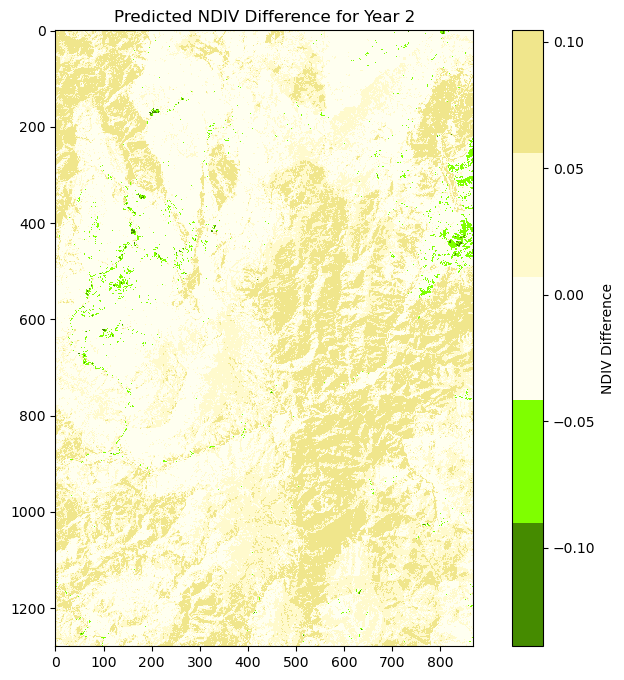

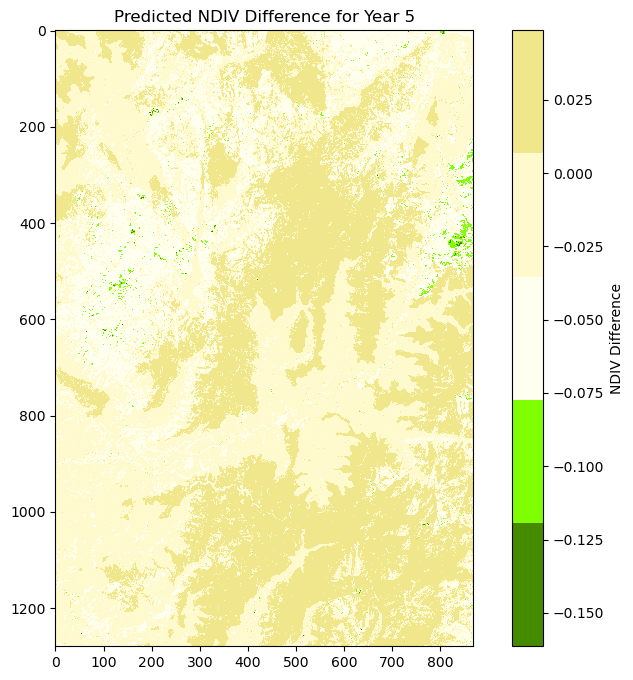

<Figure size 640x480 with 0 Axes>

In [49]:
# function to plot the NBR difference predictions
class_colors = ["#458B00", "#7FFF00", "#FFFFF0", "#FFFACD", "#F0E68C"]

def plot_nbr_predictions(predicted_nbr, title, original_shape):
    plt.figure(figsize=(10, 8))
    plt.imshow(predicted_nbr, cmap=plt.cm.colors.ListedColormap(class_colors), interpolation='nearest')
    plt.colorbar(label='NDIV Difference')
    plt.title(title)
    plt.show()

# plot the predictions for year 2 and year 5
plot_nbr_predictions(test_y_year2_pred_full, 'Predicted NDIV Difference for Year 2', test_pre_fire.shape)
plot_nbr_predictions(test_y_year5_pred_full, 'Predicted NDIV Difference for Year 5', test_pre_fire.shape)

plt.savefig('NDIV Predictions.png')

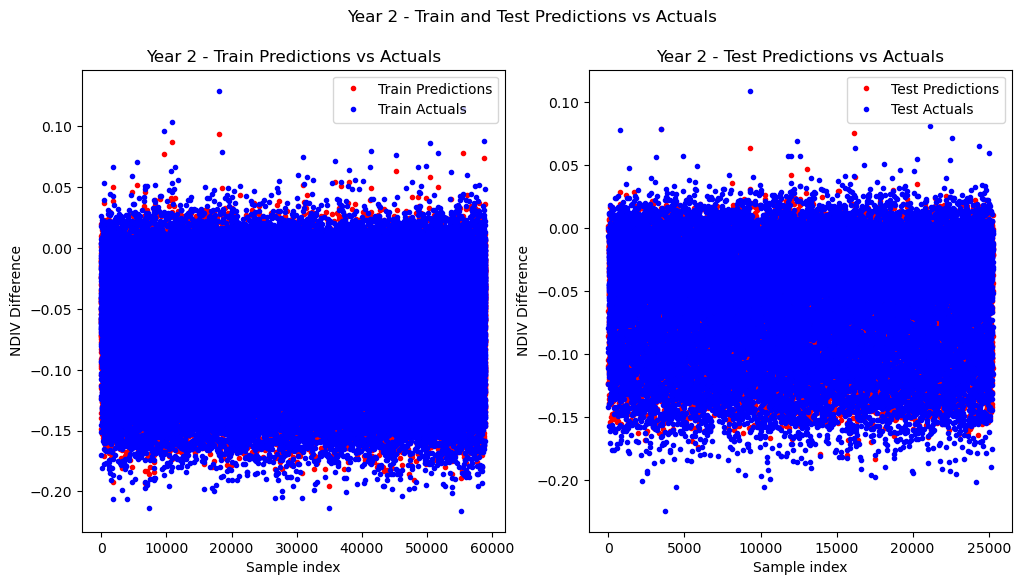

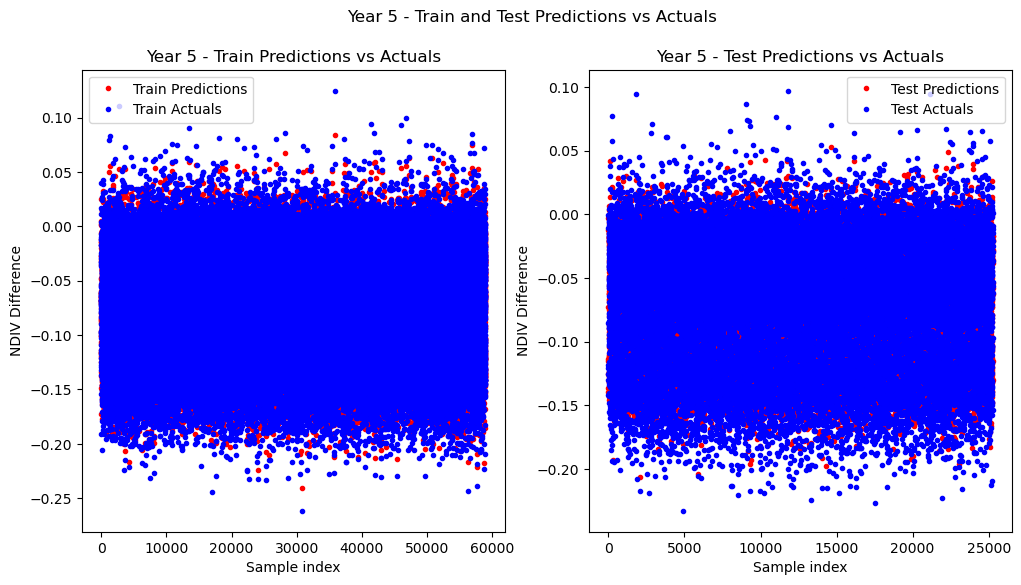

Year 2 - Train Error: 4.270536661898026e-05, Test Error: 0.00029881000233745954
Year 5 - Train Error: 6.50087123629485e-05, Test Error: 0.0004563227819323546


In [41]:
# random forest models running
rf_year2 = RandomForestRegressor(n_estimators=90, random_state=40)
rf_year5 = RandomForestRegressor(n_estimators=90, random_state=40)

rf_year2.fit(X_train, y_year2_train)
rf_year5.fit(X_train, y_year5_train)

# predict on training and testing sets
y_year2_train_pred = rf_year2.predict(X_train)
y_year2_test_pred = rf_year2.predict(X_test)
y_year5_train_pred = rf_year5.predict(X_train)
y_year5_test_pred = rf_year5.predict(X_test)

# calculate errors
train_error_year2 = mean_squared_error(y_year2_train, y_year2_train_pred)
test_error_year2 = mean_squared_error(y_year2_test, y_year2_test_pred)
train_error_year5 = mean_squared_error(y_year5_train, y_year5_train_pred)
test_error_year5 = mean_squared_error(y_year5_test, y_year5_test_pred)

# plot errors
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(X_train)), y_year2_train_pred, 'r.', label='Train Predictions')
plt.plot(range(len(X_train)), y_year2_train, 'b.', label='Train Actuals')
plt.title('Year 2 - Train Predictions vs Actuals')
plt.xlabel('Sample index')
plt.ylabel('NDIV Difference')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(X_test)), y_year2_test_pred, 'r.', label='Test Predictions')
plt.plot(range(len(X_test)), y_year2_test, 'b.', label='Test Actuals')
plt.title('Year 2 - Test Predictions vs Actuals')
plt.xlabel('Sample index')
plt.ylabel('NDIV Difference')
plt.legend()

plt.suptitle('Year 2 - Train and Test Predictions vs Actuals')
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(X_train)), y_year5_train_pred, 'r.', label='Train Predictions')
plt.plot(range(len(X_train)), y_year5_train, 'b.', label='Train Actuals')
plt.title('Year 5 - Train Predictions vs Actuals')
plt.xlabel('Sample index')
plt.ylabel('NDIV Difference')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(X_test)), y_year5_test_pred, 'r.', label='Test Predictions')
plt.plot(range(len(X_test)), y_year5_test, 'b.', label='Test Actuals')
plt.title('Year 5 - Test Predictions vs Actuals')
plt.xlabel('Sample index')
plt.ylabel('NDIV Difference')
plt.legend()

plt.suptitle('Year 5 - Train and Test Predictions vs Actuals')
plt.show()

# print errors
print(f'Year 2 - Train Error: {train_error_year2}, Test Error: {test_error_year2}')
print(f'Year 5 - Train Error: {train_error_year5}, Test Error: {test_error_year5}')


In [1]:
def plot_learning_curve(estimator, X, y, title, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")

    axes.legend(loc="best")

    return plt

# plot learning curves for both models
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

plot_learning_curve(rf_year2, X_valid, y_year2_valid, "Learning Curve for Year 2", axes=axes[0], cv=5)
plot_learning_curve(rf_year5, X_valid, y_year5_valid, "Learning Curve for Year 5", axes=axes[1], cv=5)

plt.show()


NameError: name 'np' is not defined